In [1]:
import rebound
import reboundx
import pandas as pd
import numpy as np
from numpy import genfromtxt
import csv

from IPython.display import display, clear_output
import matplotlib.pyplot as plt
from matplotlib import colors
%matplotlib inline

In [2]:
irreg_data = np.empty((59,10))
with open("irreg_jupiter_data_short.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC) # change contents to floats
    for i, row in enumerate(reader): # each row is a list
        irreg_data[i,:] = row
        
reg_data = np.empty((8,14))
with open("regular_jupiter_data_short.csv") as csvfile:
    reader = csv.reader(csvfile, quoting=csv.QUOTE_NONNUMERIC) # change contents to floats
    for i, row in enumerate(reader): # each row is a list
        reg_data[i,:] = row

radeg = np.pi/180

##############
# Above, we loaded in two files that contain orbital parameters for both regular and irregular moons
# of Jupiter. Below, we define functions that draw from those files to add moons to the system.
##############

def add_moons(sim, moons):
    for i in range(moons):
        rad = reg_data[i,0]*6.68459e-9
        ecc = reg_data[i,1]
        w = reg_data[i,2]*radeg
        incl = reg_data[i,4]*radeg
        node = reg_data[i,5]*radeg
        mass = reg_data[i,7]/(1.989e30)
        
        sim.add(m=mass, primary=sim.particles[0], a=rad, e=ecc, inc=incl, Omega=w, omega=node)
    return

def add_irregs(sim, moons):
    for i in range(moons):
        rad = irreg_data[i,0]*6.68459e-9
        ecc = irreg_data[i,1]
        w = irreg_data[i,2]*radeg
        incl = irreg_data[i,4]*radeg
        node = irreg_data[i,5]*radeg
        
        sim.add(m=0, primary=sim.particles[0], a=rad, e=ecc, inc=incl, Omega=w, omega=node)
    return

##############
# We also want to play around with some other randomly-generated, massless objects. Below,
# we define functions to add random objects around Jupiter's hill radius and in the L4 Trojan cloud
##############

def add_hillies(sim, num):
    a_rand = np.random.randint(7,9,size=num)
    a_rand = 1/a_rand
    e_rand = np.random.randint(2,10,size=num)
    e_rand = 1/e_rand
    w_rand = np.random.randint(0,360,size=num)*radeg
    half = int(num/2)
    i_rand1 = np.random.randint(0,30,size=half+1)*radeg
    i_rand2 = np.random.randint(150,180,size=half)*radeg
    i_rand = np.concatenate((i_rand1,i_rand2))
    node_rand = np.random.randint(0,360,size=num)*radeg
    
    names = ['hill1', 'hill2', 'hill3', 'hill4']
    
    for i in range(num):
        sem = a_rand[i]
        ecc = e_rand[i]
        icl = i_rand[i]
        Ome = w_rand[i]
        nod = node_rand[i]
        has = 'Hill {0}'.format(i)
        sim.add(m=0, primary=sim.particles['jupiter'], a=sem, e=ecc, inc=icl, Omega=Ome, omega=nod, hash=has)
    return

def add_L4(sim, number):
    a_rand = np.random.normal(20,2,size=number)
    a_rand = a_rand/100 + 5
    e_rand = np.random.normal(9,2,size=number)
    e_rand = e_rand/100
    w_rand = np.random.normal(160,4,size=number)*radeg
    half = int(number/2)
    i_rand1 = np.random.normal(9,4,size=half+1)*radeg
    i_rand2 = np.random.normal(-9,4,size=half)*radeg
    i_rand = np.concatenate((i_rand1,i_rand2))
    
    print(a_rand.shape, e_rand.shape, i_rand.shape)
    
    for i in range(number):
        sem = a_rand[i]
        ecc = e_rand[i]
        icl = i_rand[i]
        Ome = w_rand[i]
        has = 'L4 {0}'.format(i)
        sim.add(m=0, primary=sim.particles['Sun'], a=sem, e=ecc, inc=icl, Omega=Ome, hash=has)
    return

def add_L5(sim, number):
    a_rand = np.random.normal(20,2,size=number)
    a_rand = a_rand/100 + 5
    e_rand = np.random.normal(9,2,size=number)
    e_rand = e_rand/100
    w_rand = np.random.normal(40,4,size=number)*radeg
    half = int(number/2)
    i_rand1 = np.random.normal(9,4,size=half+1)*radeg
    i_rand2 = np.random.normal(-9,4,size=half)*radeg
    i_rand = np.concatenate((i_rand1,i_rand2))
    
    for i in range(number):
        sem = a_rand[i]
        ecc = e_rand[i]
        icl = i_rand[i]
        Ome = w_rand[i]
        has = 'L5 {0}'.format(i)
        sim.add(m=0, primary=sim.particles['Sun'], a=sem, e=ecc, inc=icl, Omega=Ome, hash=has)
    return

In [3]:
sim = rebound.Simulation()
rhill = 0.3543
radeg = np.pi/180

irrgs_add = 59
moons_add = 0
num_hillies = 6

dt_w_inners = 0.008
dt_no_inner = 0.06

# Add Jupiter and satellites

sim.add(m=9.543e-4, x=0, y=0, z=0, vx=0, vy=0, vz=0, hash='jupiter')
if (moons_add != 0):
    add_moons(sim, moons_add)
if (irrgs_add !=0):
    add_irregs(sim, irrgs_add)
if (num_hillies != 0):
    add_hillies(sim, num_hillies)

# Add Sun as Jupiter-centric; add saturn as solar-centric

sim.add(m=1,primary=sim.particles['jupiter'], a=5.2, e=.04839, inc=-.022689, Omega=-1.8, omega=-.2574, hash='Sun')
sim.add(m=2.8575e-4, primary=sim.particles['Sun'], a=9.537, e=0.05415, inc=0.043284, Omega=1.9844, omega=1.61324, hash='Saturn')

#set simulation parameters

sim.dt = dt_no_inner
sim.ri_ias15.epsilon=0

M0 = sim.particles['Sun'].m
ps = sim.particles

In [142]:
rebx = reboundx.Extras(sim)



gh = rebx.load_force("gravitational_harmonics")
rebx.add_force(gh)

mof = rebx.load_force("modify_orbits_forces")
rebx.add_force(mof)

modifymass = rebx.load_operator("modify_mass")
rebx.add_operator(modifymass)

In [143]:
J2 = 14736e-6
J2prime = 0.045020
R_jup = 0.000477895
M_jup = 9.543e-4

#factors = np.zeros(4)
#for i in range(4):
#    rad = reg_data[i,0]*6.68459e-9
#    mass = reg_data[i,7]/(1.989e30)
#    factors[i] = (rad**2 * mass) / M_jup
#J2_factor = np.sum(factors) 

#J2adj = J2 + (0.5 / R_jup**2)*J2_factor

ps['jupiter'].params["J2"] = J2prime
ps['jupiter'].params["R_eq"] = R_jup

ps['Sun'].params["tau_mass"] = -10000

#for i in range(4):
#    ps[i+1].params["tau_a"] = t_max*2

In [144]:
Nout = 1000 # number of integration checkpoints
t_max = 1e4 # total time of integration in yrs
times = np.linspace(0., t_max, Nout)

In [146]:
# initialize arrays for tracking progression of bodies over integration
num = irrgs_add

a_vals = np.zeros((num, Nout))
e_vals = np.zeros((num, Nout))
i_vals = np.zeros((num, Nout))
Omvals = np.zeros((num, Nout))

for moon in range(num):
    if (moons_add == 0):
        a_vals[moon,0] = ps[moon + 1].a
        e_vals[moon,0] = ps[moon + 1].e
        i_vals[moon,0] = ps[moon + 1].inc
        Omvals[moon,0] = ps[moon + 1].pomega
    else:
        a_vals[moon,0] = ps[moon + len(moons_add) + 1].a
        e_vals[moon,0] = ps[moon + len(moons_add) + 1].e
        i_vals[moon,0] = ps[moon + len(moons_add) + 1].inc
        Omvals[moon,0] = ps[moon + len(moons_add) + 1].omega

mass = np.zeros(Nout)
a_sun = np.zeros(Nout)

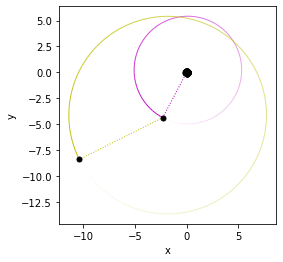

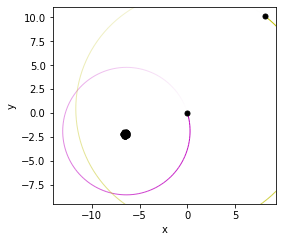

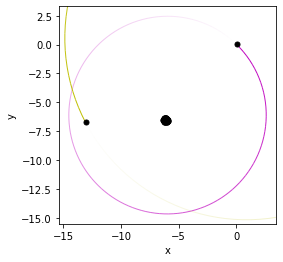

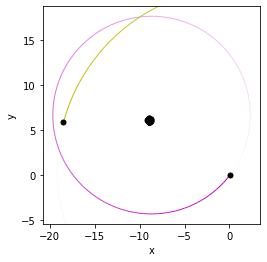

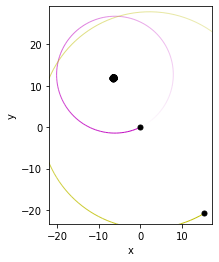

In [147]:
for i, time in enumerate(times):
    sim.integrate(time)
    mass[i] = sim.particles['Sun'].m
    a_sun[i] = sim.particles['Sun'].a

    if i == 0:
        fig = rebound.OrbitPlot(sim, figsize=(4,4), color=True, periastron=True)
    if (i+1)%(Nout/4) == 0:
        fig = rebound.OrbitPlot(sim, figsize=(4,4), color=True)
    
    for moon in range(num):
        a_vals[moon, i] = ps[moon + 2].a
        e_vals[moon, i] = ps[moon + 2].e
        i_vals[moon, i] = ps[moon + 2].inc
        Omvals[moon, i] = ps[moon + 2].omega

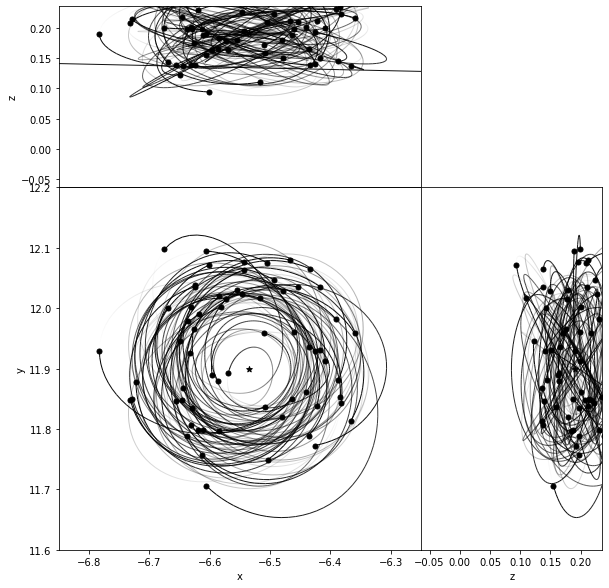

In [155]:
fig = rebound.OrbitPlot(sim, slices=0.5, xlim=[-6.85, -6.25], ylim=[11.6,12.2], figsize=(10,10))

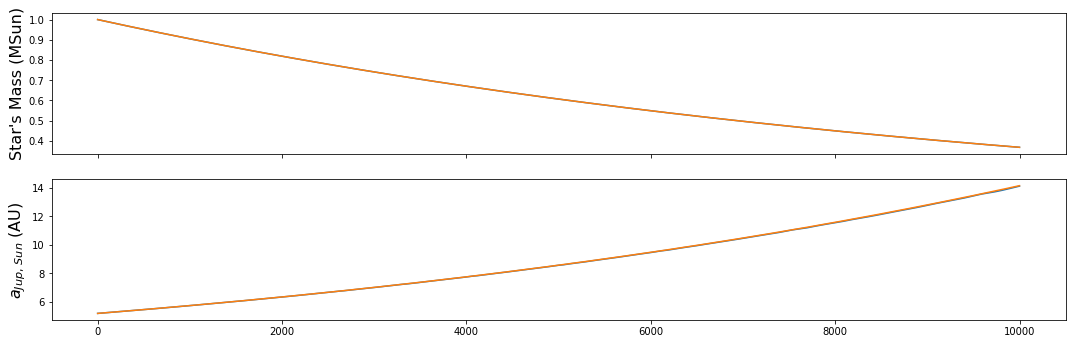

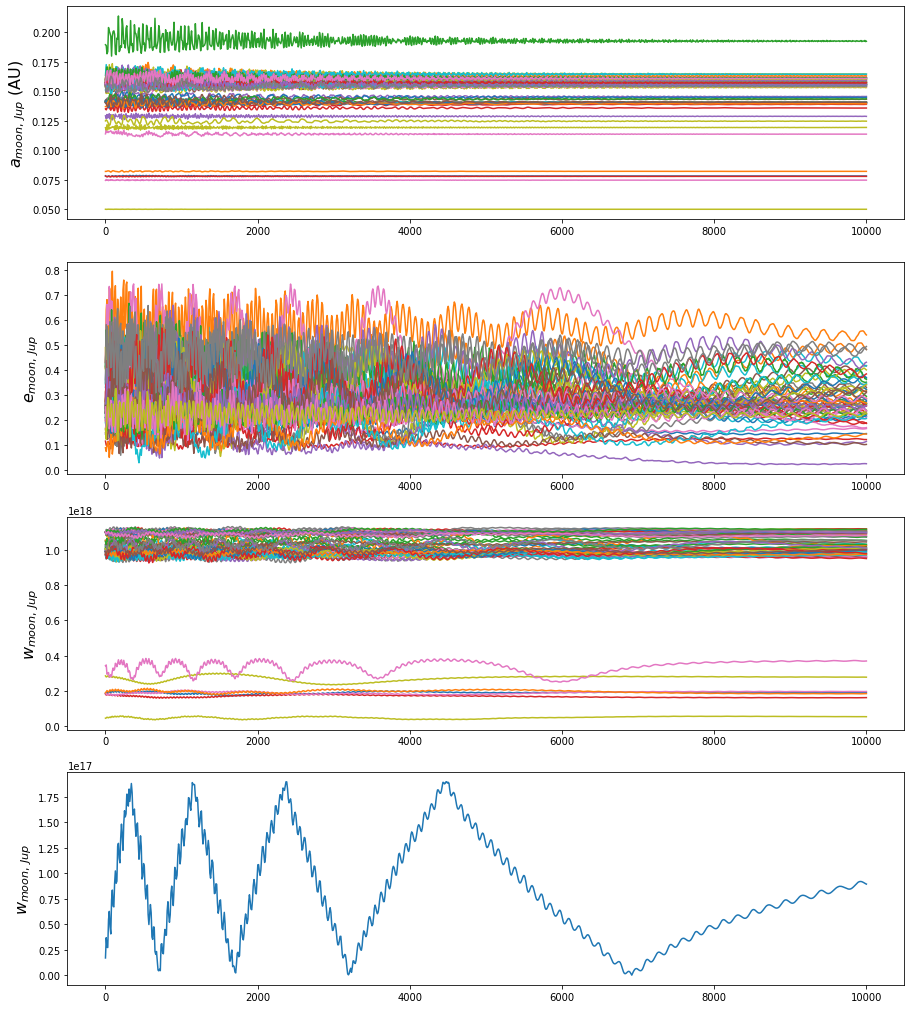

In [164]:
i_vals /= radeg
Omvals /= radeg

pred = M0*np.e**(times/ps['Sun'].params["tau_mass"])
apre = a_sun[0]*np.e**(-times/ps['Sun'].params["tau_mass"])

fig, ax = plt.subplots(2,1,figsize=(15,5), sharex=True)

ax[0].plot(times,mass, label='simulation')
ax[0].plot(times,pred, label='predicted')
ax[0].set_ylabel("Star's Mass (MSun)", fontsize=16)
ax[1].plot(times,a_sun)
ax[1].plot(times,apre)
ax[1].set_ylabel(r"$a_{Jup,\,Sun}$" + " (AU)", fontsize=16)

fig.tight_layout()

trojs, axes = plt.subplots(4,1,figsize=(15,18))

axes[0].plot(times, a_vals.T)
axes[0].set_ylabel(r"$a_{moon,\,Jup}$" + " (AU)", fontsize=16)
axes[1].plot(times, e_vals.T)
axes[1].set_ylabel(r"$e_{moon,\,Jup}$", fontsize=16)
axes[2].plot(times, i_vals.T)
axes[2].set_ylabel(r"$w_{moon,\,Jup}$", fontsize=16)
axes[3].plot(times, Omvals.T[:,5])
axes[3].set_ylabel(r"$w_{moon,\,Jup}$", fontsize=16)

plt.show()

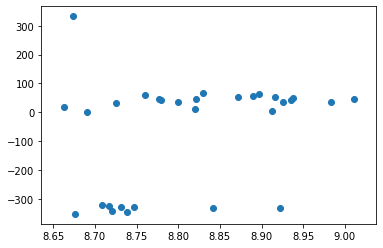

In [35]:
t_top = Nout - 1 #int(t_max - 1)

da = a_vals[:,t_top] - a_vals[:,0]
de = e_vals[:,t_top] - e_vals[:,0]
di = i_vals[:,t_top] - i_vals[:,0]
dw = Omvals[:,t_top] - Omvals[:,0]

plt.scatter(da, dw)
plt.show()

data = [de, de]

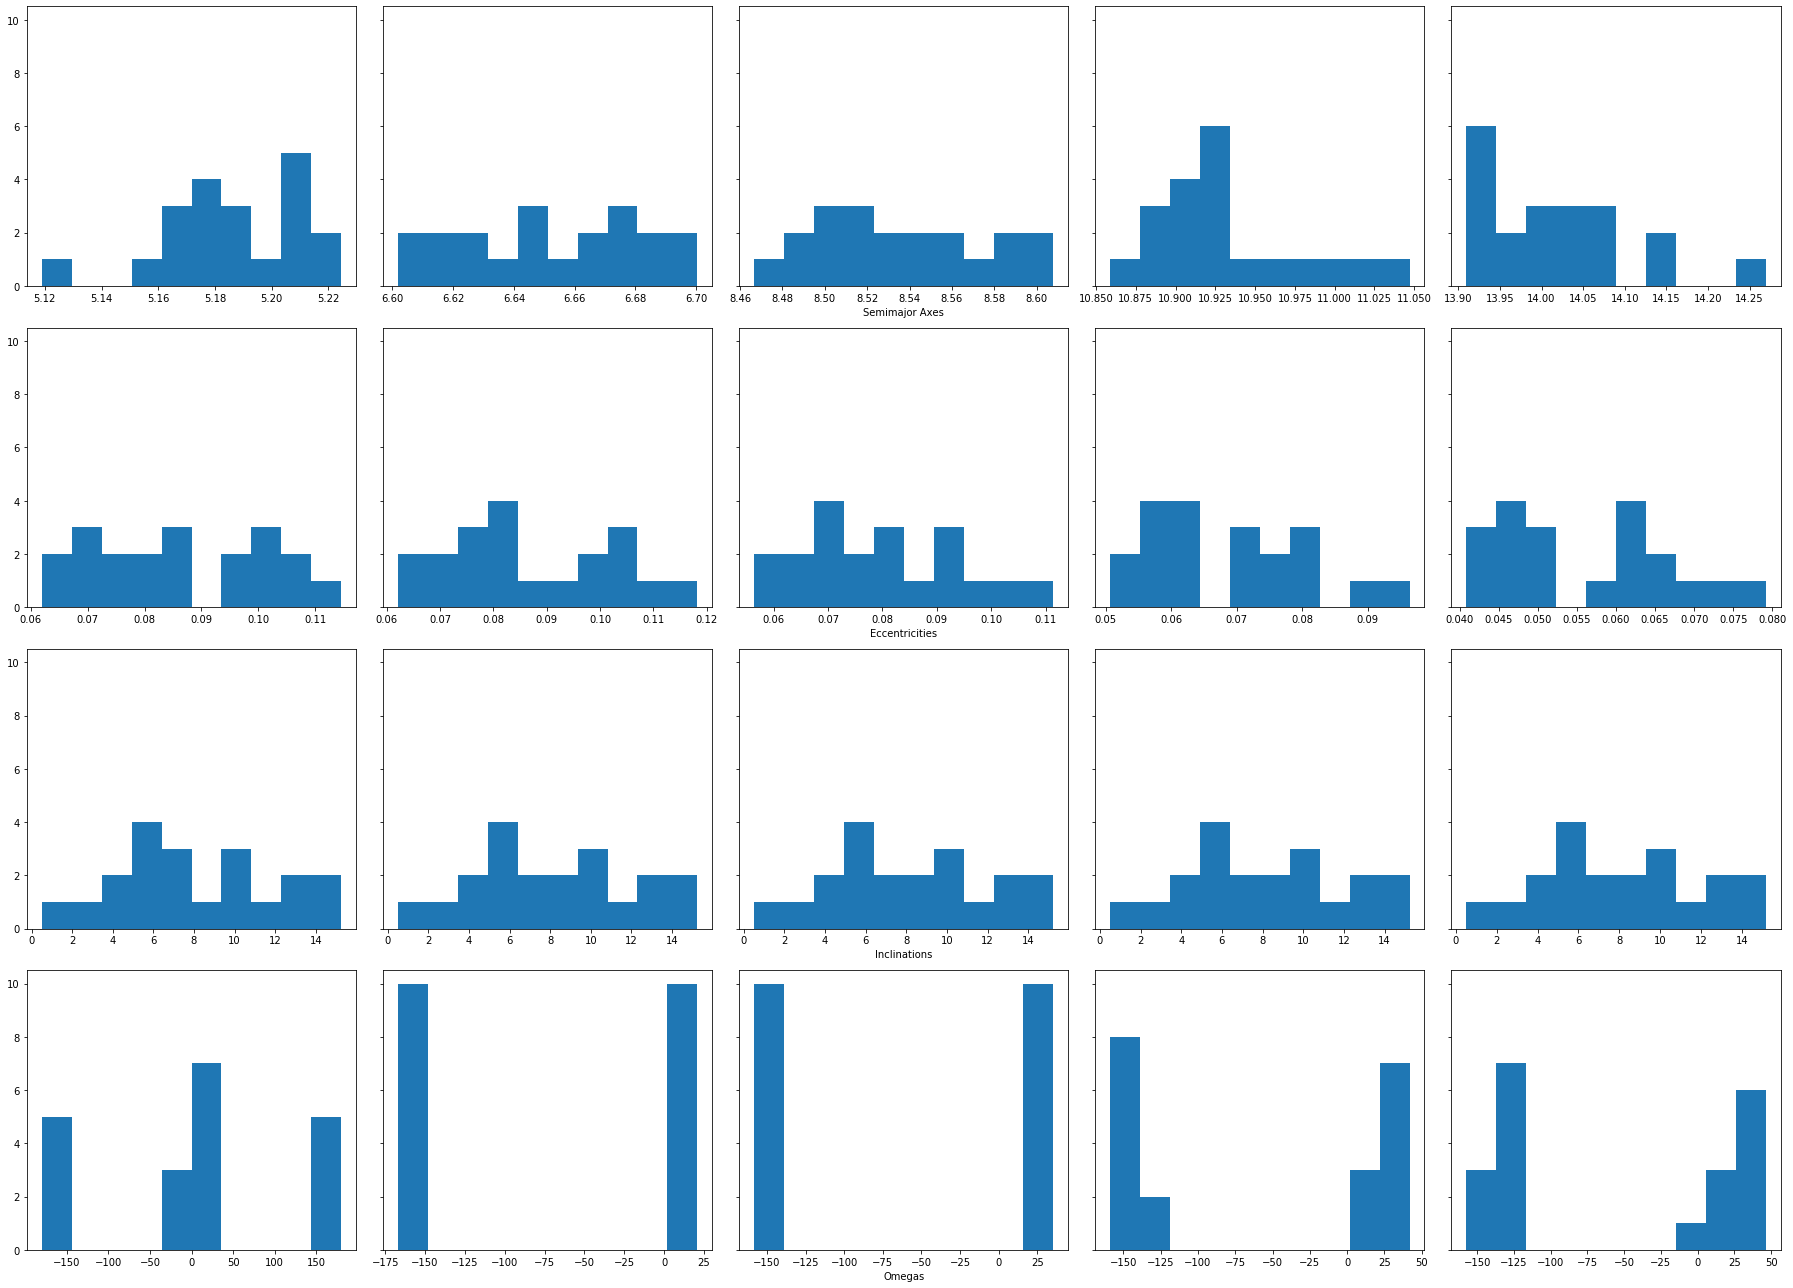

In [21]:
hists, hax = plt.subplots(4,5,figsize=(25,18), sharey=True)

(t1, t2, t3, t4) = (int(Nout/4 - 1), int(Nout/2 - 1), int(3*Nout/4 - 1), int(Nout - 1))

hax[0,0].hist(a_vals[:,0], 10)
hax[0,1].hist(a_vals[:,t1], 10)
hax[0,2].hist(a_vals[:,t2], 10)
hax[0,3].hist(a_vals[:,t3], 10)
hax[0,4].hist(a_vals[:,t4], 10)
hax[0,2].set_xlabel("Semimajor Axes")

hax[1,0].hist(e_vals[:,0], 10)
hax[1,1].hist(e_vals[:,t1], 10)
hax[1,2].hist(e_vals[:,t2], 10)
hax[1,3].hist(e_vals[:,t3], 10)
hax[1,4].hist(e_vals[:,t4], 10)
hax[1,2].set_xlabel("Eccentricities")

hax[2,0].hist(i_vals[:,0], 10)
hax[2,1].hist(i_vals[:,t1], 10)
hax[2,2].hist(i_vals[:,t2], 10)
hax[2,3].hist(i_vals[:,t3], 10)
hax[2,4].hist(i_vals[:,t4], 10)
hax[2,2].set_xlabel("Inclinations")

hax[3,0].hist(Omvals[:,0], 10)
hax[3,1].hist(Omvals[:,t1], 10)
hax[3,2].hist(Omvals[:,t2], 10)
hax[3,3].hist(Omvals[:,t3], 10)
hax[3,4].hist(Omvals[:,t4], 10)
hax[3,2].set_xlabel("Omegas")

hists.tight_layout()

# Trojan analysis

In [242]:
sim = rebound.Simulation()
radeg = np.pi/180
Om_jup = 100.556*radeg
om_jup = 14.753*radeg

num_L4 = 10
num_L5 = 10

# Add sun and jupiter

sim.add(m=1,x=0, y=0, z=0, vx=0, vy=0, vz=0, hash='Sun')
sim.add(m=9.543e-4, a=5.2, e=.04839, inc=.022689, Omega=Om_jup, omega=om_jup, hash='jupiter')

# add trojans and saturn as heliocentric

add_L4(sim, num_L4)
add_L5(sim, num_L5)
sim.add(m=2.8575e-4, primary=sim.particles['Sun'], a=9.537, e=0.05415, inc=0.043284, Omega=1.9844, omega=1.61324, hash='Saturn')

#set simulation parameters

sim.dt = 0.06
sim.ri_ias15.epsilon=0

M0 = sim.particles['Sun'].m
ps = sim.particles

(10,) (10,) (11,)


In [243]:
rebx = reboundx.Extras(sim)

gh = rebx.load_force("gravitational_harmonics")
rebx.add_force(gh)

mof = rebx.load_force("modify_orbits_forces")
rebx.add_force(mof)

modifymass = rebx.load_operator("modify_mass")
rebx.add_operator(modifymass)

J2 = 14736e-6
J2prime = 0.045020
R_jup = 0.000477895

ps['jupiter'].params["J2"] = J2prime
ps['jupiter'].params["R_eq"] = R_jup

ps['Sun'].params["tau_mass"] = -10000

In [244]:
Nout = 1000
tmax = 1e4
times = np.linspace(0, tmax, Nout)

In [245]:
# initialize arrays for tracking progression of bodies over integration

num_tot = num_L4 + num_L5

a_vals = np.zeros((num_tot, Nout))
e_vals = np.zeros((num_tot, Nout))
i_vals = np.zeros((num_tot, Nout))
Omvals = np.zeros((num_tot, Nout))

for moon in range(num_L4):
    a_vals[moon,0] = ps['L4 {0}'.format(moon)].a
    e_vals[moon,0] = ps['L4 {0}'.format(moon)].e
    i_vals[moon,0] = ps['L4 {0}'.format(moon)].inc
    Omvals[moon,0] = ps['L4 {0}'.format(moon)].l
    
for moon in range(num_L5):
    a_vals[moon + num_L4,0] = ps['L5 {0}'.format(moon)].a
    e_vals[moon + num_L4,0] = ps['L5 {0}'.format(moon)].e
    i_vals[moon + num_L4,0] = ps['L5 {0}'.format(moon)].inc
    Omvals[moon + num_L4,0] = ps['L5 {0}'.format(moon)].l

mass = np.zeros(Nout)
a_jup = np.zeros(Nout)

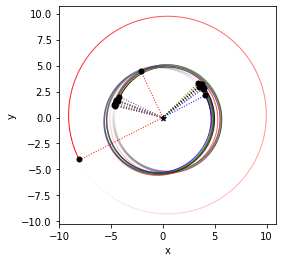

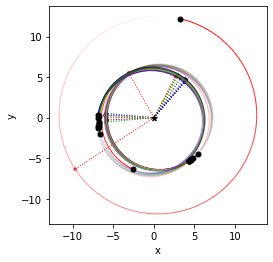

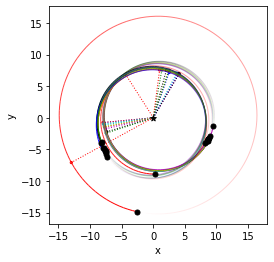

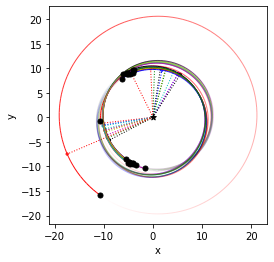

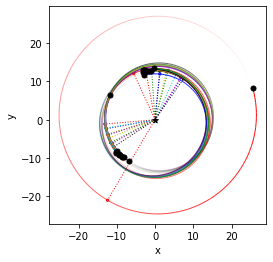

In [246]:
for i, time in enumerate(times):
    sim.integrate(time)
    mass[i] = sim.particles['Sun'].m
    a_jup[i] = sim.particles['jupiter'].a

    if i == 0:
        fig = rebound.OrbitPlot(sim, figsize=(4,4), color=True, periastron=True)
    if (i+1)%(Nout/4) == 0:
        fig = rebound.OrbitPlot(sim, figsize=(4,4), color=True, periastron=True)
    
    for moon in range(num_L4):
        a_vals[moon,i] = ps['L4 {0}'.format(moon)].a
        e_vals[moon,i] = ps['L4 {0}'.format(moon)].e
        i_vals[moon,i] = ps['L4 {0}'.format(moon)].inc
        Omvals[moon,i] = ps['L4 {0}'.format(moon)].l
    
    for moon in range(num_L5):
        a_vals[moon + num_L4,i] = ps['L5 {0}'.format(moon)].a
        e_vals[moon + num_L4,i] = ps['L5 {0}'.format(moon)].e
        i_vals[moon + num_L4,i] = ps['L5 {0}'.format(moon)].inc
        Omvals[moon + num_L4,i] = ps['L5 {0}'.format(moon)].l

In [238]:
def change(variable, time):
# takes an array of values for an orbital element over time and computes a simple derivative for that element
    mask = np.zeros(len(time))
    for i in range(len(time))
        if i == 0:
            mask[i] = 1
        if (i+1)%(len(time)/50) == 0:
            mask[i] = 1

    vari_masked = 
    time_masked
    
    derivative = np.zeros_like(vari_masked)
    for i in range(len(vari_masked[:,0]) - 1):
            derivative[i,:] = (variable[i+1,:] - variable[i,:])/dt_
    return derivative

SyntaxError: invalid syntax (<ipython-input-238-70132f54103c>, line 4)

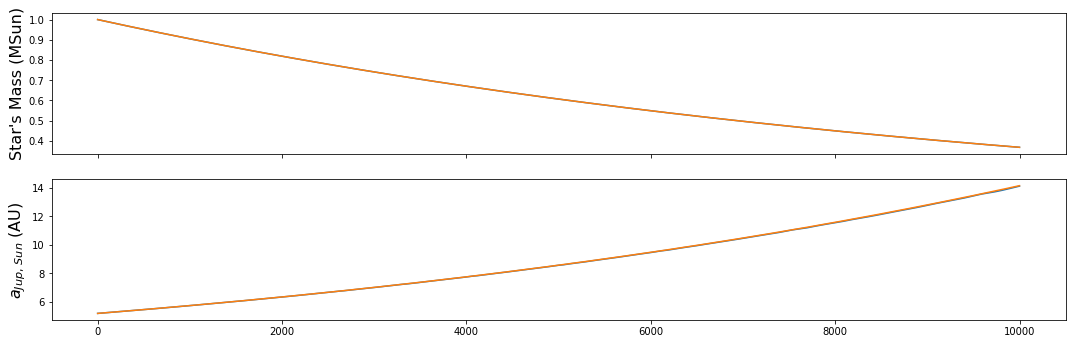

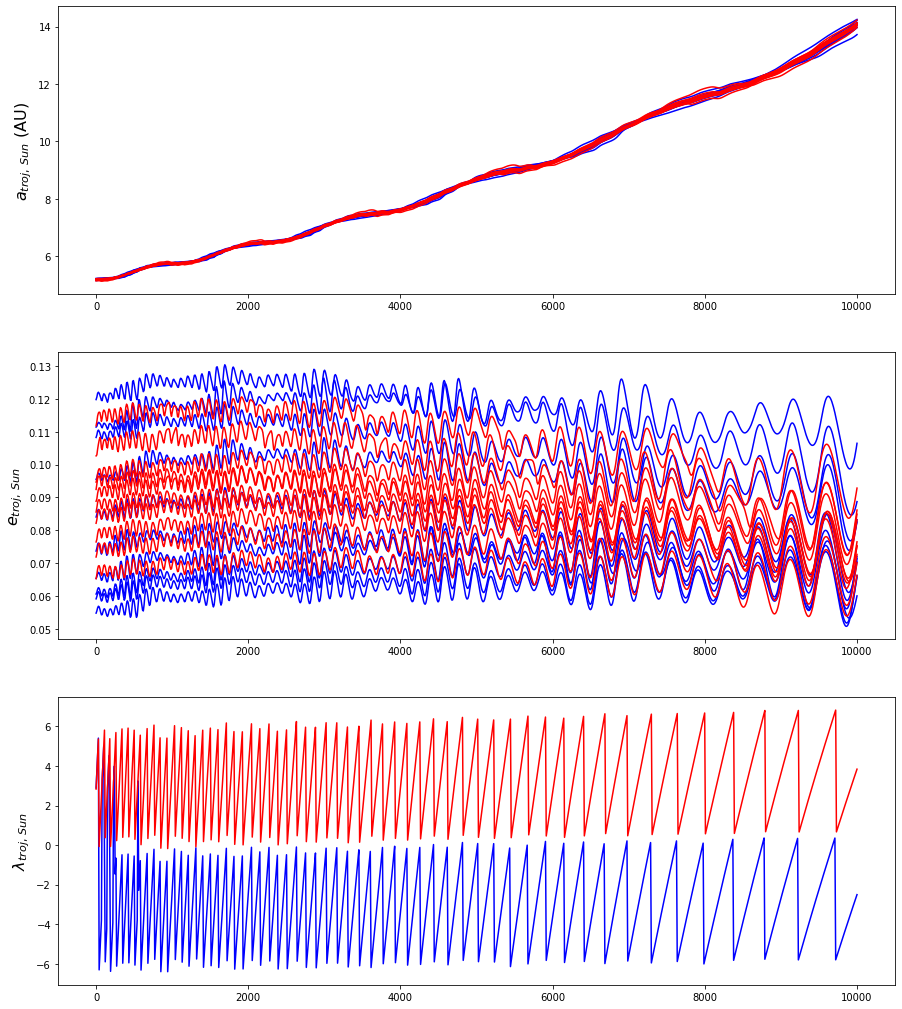

In [256]:
i_vals /= radeg

pred = M0*np.e**(times/ps['Sun'].params["tau_mass"])
apre = a_sun[0]*np.e**(-times/ps['Sun'].params["tau_mass"])

fig, ax = plt.subplots(2,1,figsize=(15,5), sharex=True)

ax[0].plot(times,mass, label='simulation')
ax[0].plot(times,pred, label='predicted')
ax[0].set_ylabel("Star's Mass (MSun)", fontsize=16)
ax[1].plot(times,a_sun)
ax[1].plot(times,apre)
ax[1].set_ylabel(r"$a_{Jup,\,Sun}$" + " (AU)", fontsize=16)

fig.tight_layout()

trojs, axes = plt.subplots(3,1,figsize=(15,18))

axes[0].plot(times, a_vals.T[:, num_L4:], 'b')
axes[0].plot(times, a_vals.T[:, :num_L4], 'r')
axes[0].set_ylabel(r"$a_{troj,\,Sun}$" + " (AU)", fontsize=16)
axes[1].plot(times, e_vals.T[:, num_L4:], 'b')
axes[1].plot(times, e_vals.T[:, :num_L4], 'r')
axes[1].set_ylabel(r"$e_{troj,\,Sun}$", fontsize=16)
axes[2].plot(times[:1000], Omvals.T[:1000, 6], 'b')
axes[2].plot(times[:1000], Omvals.T[:1000, 2], 'r')
#axes[2].plot(times, change(Omvals.T)[:,1], 'k', a=3)
axes[2].set_ylabel(r"$\lambda_{troj,\,Sun}$", fontsize=16)

plt.show()

In [257]:
print(Omvals.T[Nout-1,:num_L4]- Omvals.T[0,:num_L4])
print(Omvals.T[Nout-1,num_L4:]- Omvals.T[0,num_L4:])

[ 1.17663838  1.37235279  1.00671094  1.10652498  1.10946931  0.90341109
 -5.39757886 -5.28581582 -5.36419999 -5.13740039]
[1.13741767 0.96960691 0.99390166 0.97960366 1.08456157 1.08075685
 0.95686808 1.00778105 1.27176202 0.78171983]
